## Portfolio Optimization

In [35]:
# importing libraries

import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import yfinance as yf
from scipy.optimize import minimize

#### Define tickers and time range

In [36]:
tickers=['SPY','BND','GLD','QQQ','VTI']

In [37]:
#set end date to today
end_date = datetime.today()

# set start date to 10 years ago
start_date = end_date - timedelta(days= 10* 365)


### download adjusted close price

In [38]:
# craete an empty dataframe to store the adjusted close prices
adj_close_df=pd.DataFrame()

In [39]:
# Downloading data from Yahoo Finance
for ticker in tickers:
    data = yf.download(ticker, start=start_date,end=end_date, auto_adjust=False)  # The raw 'Close' and other prices are not adjusted. The 'Adj Close' column is included.
    adj_close_df[ticker] = data['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [40]:
# display the dataframe
print(adj_close_df)

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2015-06-17  177.184814  61.506413  113.849998  101.047386   92.153976
2015-06-18  179.027466  61.461060  115.320000  102.520020   93.064240
2015-06-19  178.232727  61.634762  115.120003  102.013184   92.659683
2015-06-22  179.145828  61.340271  113.639999  102.765106   93.224365
2015-06-23  179.272644  61.196758  112.889999  102.848663   93.317085
...                ...        ...         ...         ...         ...
2025-06-09  599.679993  72.320000  306.619995  530.700012  295.359985
2025-06-10  603.080017  72.459999  306.709991  534.210022  296.920013
2025-06-11  601.359985  72.690002  308.369995  532.409973  296.130005
2025-06-12  603.750000  72.959999  312.200012  533.659973  297.079987
2025-06-13  601.030029  72.610001  316.035004  531.190002  295.728790

[2514 rows x 5 columns]


### calculating lognormal returns

In [41]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))

In [42]:
# drop missing values
log_returns=log_returns.dropna()

### calculate the covariance matrix

In [43]:
cov_matrix = log_returns.cov() * 252  # Annualize the covariance matrix
print("Covariance Matrix:\n", cov_matrix)

Covariance Matrix:
           SPY       BND       GLD       QQQ       VTI
SPY  0.033682  0.001151  0.001247  0.038807  0.034189
BND  0.001151  0.003043  0.002745  0.001433  0.001241
GLD  0.001247  0.002745  0.020839  0.001842  0.001356
QQQ  0.038807  0.001433  0.001842  0.051262  0.039332
VTI  0.034189  0.001241  0.001356  0.039332  0.034974


### define portfolio performance matrics

In [44]:
# calculate the portfolio standard deviation
def std_dev(weights,cov_matrix):
    variance= weights.T@ cov_matrix @ weights
    return np.sqrt(variance)

In [45]:
# calculate the expected portfolio return

# * key assumption: the expected returns are based on historical returns
def expected_return(weights,log_retuerns):
    return np.sum(weights * log_returns.mean()) * 252  # Annualize the expected return


In [46]:
# calculate the sharpe ratio
# sharpe ratio = (expected return - risk free rate) / standard deviation

def sharpe_ratio(weights,log_returns,risk_free_rate=0.02):
    return(expected_return(weights,log_returns)-risk_free_rate)/std_dev(weights,cov_matrix)

In [47]:
# define the function to minimize (negative sharpe ratio)
def neg_sharpe_ratio(weights,log_returns,cov_matrix,risk_free_rate=0.02):
    return -sharpe_ratio(weights,log_returns,risk_free_rate)

In [48]:
# set constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # weights must sum to 1
bounds = tuple((0, 0.5) for _ in range(len(tickers)))  # weights must be between 0 and 0.5



In [49]:
# set the initial weights
initial_weights = np.array([1/len(tickers)] * len(tickers))  # equal weights



In [50]:
# optimize the weights to maximize the sharpe ratio
result = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)

In [51]:
# get the optimal weights
optimal_weights = result.x

### Analyze the optimal portfolio

In [52]:
# display the optimal portfolio 
print("Optimal Weights:\n", optimal_weights)
for ticker,weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4%}")
print("Expected Portfolio Return: {:.4%}".format(expected_return(optimal_weights, log_returns)))

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = std_dev(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Portfolio Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Optimal Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
 [1.38777878e-17 1.80411242e-16 5.00000000e-01 5.00000000e-01
 0.00000000e+00]
SPY: 0.0000%
BND: 0.0000%
GLD: 50.0000%
QQQ: 50.0000%
VTI: 0.0000%
Expected Portfolio Return: 13.4398%
Expected Annual Return: 0.1344
Expected Portfolio Volatility: 0.1376
Optimal Sharpe Ratio: 0.8311


### display the final portfolio in plot

Text(0.5, 1.0, 'Optimal Portfolio Weights')

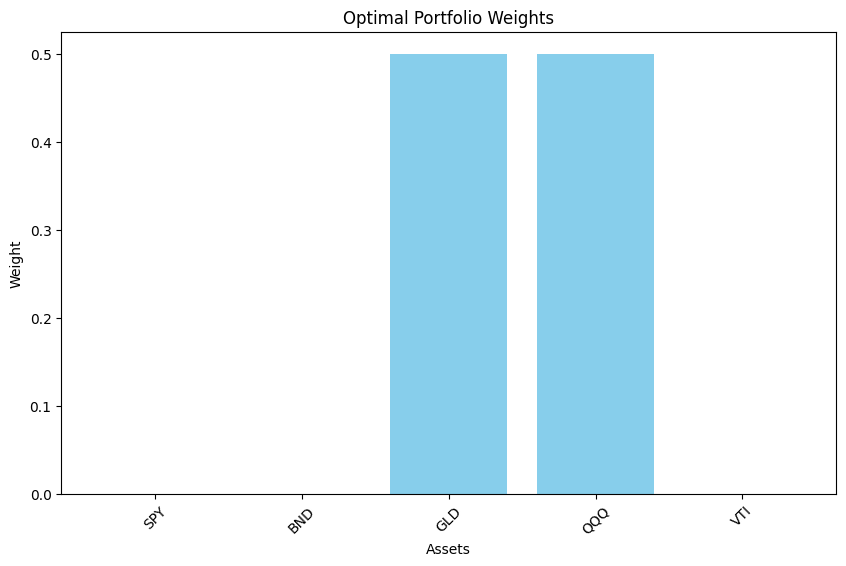

In [53]:
import matplotlib.pyplot as plt

# create a bar chart for the optimal weights
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights, color='skyblue')
plt.title('Optimal Portfolio Weights')
plt.xlabel('Assets')
plt.ylabel('Weight')
plt.xticks(rotation=45)
plt.title('Optimal Portfolio Weights')

